<h1 align="center">Rainfall Predict with LSTM and LSTM Attention </h1>



In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 33.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


Import the library needed

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, root_mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Attention, Add, Concatenate, Input, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import sklearn
import seaborn as sns

Read data

In [ ]:
# Membaca data keseluruhan
rainfall_data_url = "https://raw.githubusercontent.com/arifian853/rainfall-predict-lstm-attention/master/dataset/cleaned/data_cleaned.csv"
df = pd.read_csv(rainfall_data_url, parse_dates=['Date'], index_col='Date')

Separate data and feature selection

In [ ]:
# Membagi data menjadi training, validation, dan testing sets
train = df['01/01/2019':'31/12/2021']
validation = df['01/01/2022':'31/12/2022']
test = df['01/01/2023':'31/12/2023']

# Memilih fitur dan target
features = ['Tavg', 'RH_avg', 'ss', 'ff_avg']
X_train = train[features]
y_train = train['RR']
X_val = validation[features]
y_val = validation['RR']
X_test = test[features]
y_test = test['RR']

Confusion matrix and correlation matrix

<Axes: >

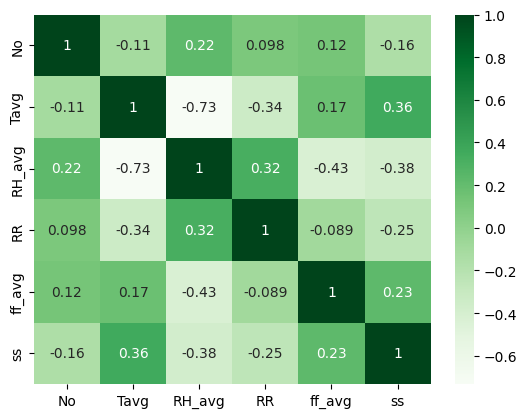

In [ ]:
matrix = df.corr()

#plotting correlation matrix
sns.heatmap(matrix, cmap="Greens", annot=True)

Normalization and convert to sequence the data

In [ ]:
# Normalisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Fungsi untuk membentuk data menjadi sequence
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10  # Misalnya, gunakan 10 hari sebelumnya untuk memprediksi hari berikutnya
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, time_steps)

Data shape verification

In [ ]:
# Verifikasi bentuk data
print("Shape of X_train_seq:", X_train_seq.shape)
print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of X_val_seq:", X_val_seq.shape)
print("Shape of y_val_seq:", y_val_seq.shape)
print("Shape of X_test_seq:", X_test_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)

Shape of X_train_seq: (1086, 10, 4)
Shape of y_train_seq: (1086,)
Shape of X_val_seq: (355, 10, 4)
Shape of y_val_seq: (355,)
Shape of X_test_seq: (355, 10, 4)
Shape of y_test_seq: (355,)


Regular LSTM model build and training

In [ ]:
# Membangun model LSTM biasa
def build_lstm_model(input_shape, units=100, learning_rate=0.01, l2_lambda=0.01):
    model = Sequential()
    model.add(LSTM(units, activation='tanh', input_shape=input_shape, kernel_regularizer=l2(l2_lambda), time_major=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.add(Dropout(0.2))
    model.compile(optimizer=optimizer, loss='mae')
    return model

# Membangun model LSTM dengan Attention Mechanism
input_shape = (time_steps, X_train_seq.shape[2])
model_lstm = build_lstm_model(input_shape)

# Melatih model LSTM
history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_data=(X_val_seq, y_val_seq))

# Evaluasi model LSTM
y_pred_lstm = model_lstm.predict(X_test_seq)
mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
rmse_lstm = root_mean_squared_error(y_test_seq, y_pred_lstm)
print(f'MSE LSTM: {mse_lstm}')
print(f'MAE LSTM: {mae_lstm}')
print(f'RMSE LSTM: {rmse_lstm}')


Epoch 1/200
34/34 [==============================] - 15s 27ms/step - loss: 7.3446 - val_loss: 7.8870
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 7.0954 - val_loss: 7.9510
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 7.0756 - val_loss: 8.2871
Epoch 4/200
34/34 [==============================] - 0s 11ms/step - loss: 7.1491 - val_loss: 7.8584
Epoch 5/200
34/34 [==============================] - 0s 11ms/step - loss: 6.9866 - val_loss: 7.7546
Epoch 6/200
34/34 [==============================] - 0s 12ms/step - loss: 7.0453 - val_loss: 7.7892
Epoch 7/200
34/34 [==============================] - 0s 11ms/step - loss: 7.0435 - val_loss: 7.8019
Epoch 8/200
34/34 [==============================] - 0s 12ms/step - loss: 7.0373 - val_loss: 7.9125
Epoch 9/200
34/34 [==============================] - 0s 12ms/step - loss: 7.1205 - val_loss: 7.8817
Epoch 10/200
34/34 [==============================] - 0s 11ms/step - loss: 6.9444 - val_loss: 7.864

LSTM Attention Mechanism model build and training

In [ ]:
# Fungsi untuk membuat model LSTM dengan Attention Mechanism
def build_lstm_attention_model(input_shape, lstm_units=100, lstm_units_2=50, learning_rate=0.01, l2_lambda=0.01, dropout_rate=0.5):
      inputs = Input(shape=input_shape)
      lstm_out = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(l2_lambda), time_major=False)(inputs)
      attention = Attention()([lstm_out, lstm_out])
      context_vector = Add()([lstm_out, attention])
      context_vector = LSTM(lstm_units_2, activation='tanh', kernel_regularizer=l2(l2_lambda))(context_vector)
      context_vector = Dropout(dropout_rate)(context_vector)
      outputs = Dense(1)(context_vector)
      model = Model(inputs, outputs)
      optimizer = Adam(learning_rate=learning_rate)
      model.compile(optimizer=optimizer, loss='mae')
      return model

# Membangun model LSTM dengan Attention Mechanism
input_shape = (time_steps, X_train_seq.shape[2])
model_lstm_attention = build_lstm_attention_model(input_shape)

# Melatih model LSTM dengan Attention Mechanism
history_lstm_attention = model_lstm_attention.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_data=(X_val_seq, y_val_seq))

# Evaluasi model LSTM dengan Attention Mechanism
y_pred_lstm_attention = model_lstm_attention.predict(X_test_seq)
mse_lstm_attention = mean_squared_error(y_test_seq, y_pred_lstm_attention)
mae_lstm_attention = mean_absolute_error(y_test_seq, y_pred_lstm_attention)
rmse_lstm_attention = root_mean_squared_error(y_test_seq, y_pred_lstm_attention)
print(f'MSE LSTM with Attention: {mse_lstm_attention}')
print(f'MAE LSTM with Attention: {mae_lstm_attention}')
print(f'RMSE LSTM with Attention: {rmse_lstm_attention}')


Epoch 1/200
34/34 [==============================] - 6s 55ms/step - loss: 7.6217 - val_loss: 8.1851
Epoch 2/200
34/34 [==============================] - 1s 21ms/step - loss: 7.1699 - val_loss: 7.8462
Epoch 3/200
34/34 [==============================] - 1s 30ms/step - loss: 7.1451 - val_loss: 7.9656
Epoch 4/200
34/34 [==============================] - 1s 29ms/step - loss: 7.1253 - val_loss: 7.8510
Epoch 5/200
34/34 [==============================] - 1s 30ms/step - loss: 7.0136 - val_loss: 7.8918
Epoch 6/200
34/34 [==============================] - 1s 23ms/step - loss: 7.0220 - val_loss: 8.0060
Epoch 7/200
34/34 [==============================] - 1s 19ms/step - loss: 7.0873 - val_loss: 7.9021
Epoch 8/200
34/34 [==============================] - 1s 19ms/step - loss: 6.9663 - val_loss: 7.9003
Epoch 9/200
34/34 [==============================] - 1s 19ms/step - loss: 6.9155 - val_loss: 7.8973
Epoch 10/200
34/34 [==============================] - 1s 19ms/step - loss: 6.8529 - val_loss: 7.8198

Result and evaluation

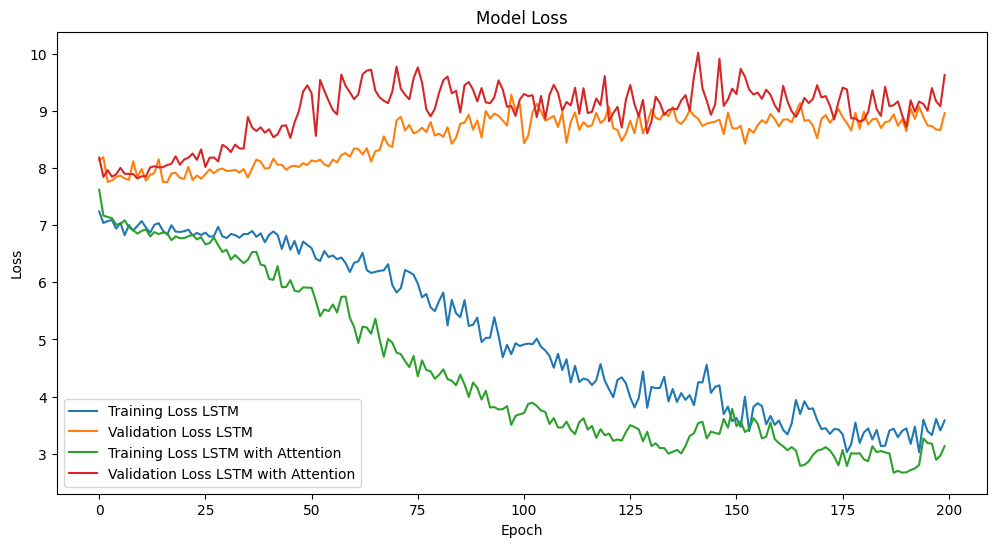

MSE LSTM: 547.6124004714167
MAE LSTM: 10.328891762652868
RMSE LSTM : 23.401119641406407
MSE LSTM with Attention: 498.1632458592052
MAE LSTM with Attention: 10.194920564559144
RMSE LSTM with Attention: 22.31957091566066


In [ ]:
# Plot hasil pelatihan
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss LSTM')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss LSTM')
plt.plot(history_lstm_attention.history['loss'], label='Training Loss LSTM with Attention')
plt.plot(history_lstm_attention.history['val_loss'], label='Validation Loss LSTM with Attention')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Menampilkan hasil evaluasi
print(f'MSE LSTM: {mse_lstm}')
print(f'MAE LSTM: {mae_lstm}')
print(f'RMSE LSTM : {rmse_lstm}')
print(f'MSE LSTM with Attention: {mse_lstm_attention}')
print(f'MAE LSTM with Attention: {mae_lstm_attention}')
print(f'RMSE LSTM with Attention: {rmse_lstm_attention}')


Nilai prediksi dan nilai asli LSTM Regular

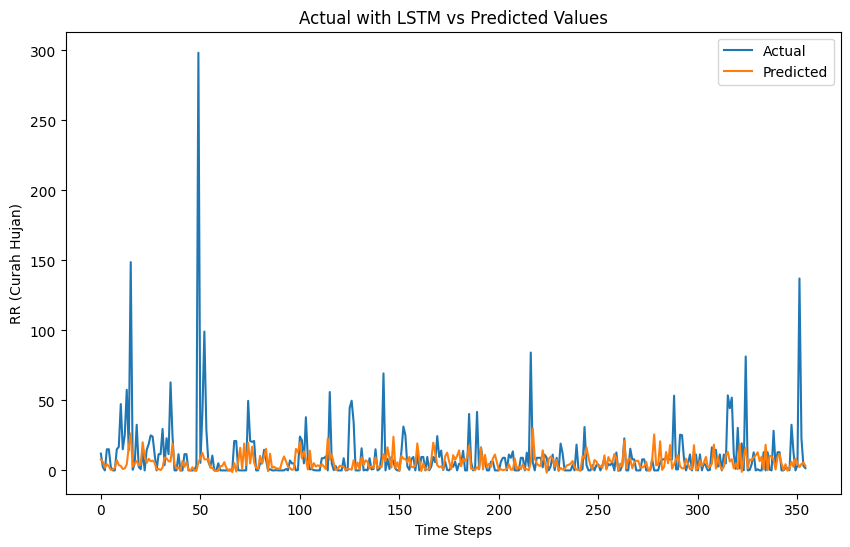

In [ ]:
# Plot prediksi vs nilai sebenarnya
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_lstm, label='Predicted')
plt.title('Actual with LSTM vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('RR (Curah Hujan)')
plt.legend()
plt.show()

Nilai prediksi dan nilai asli LSTM Attention

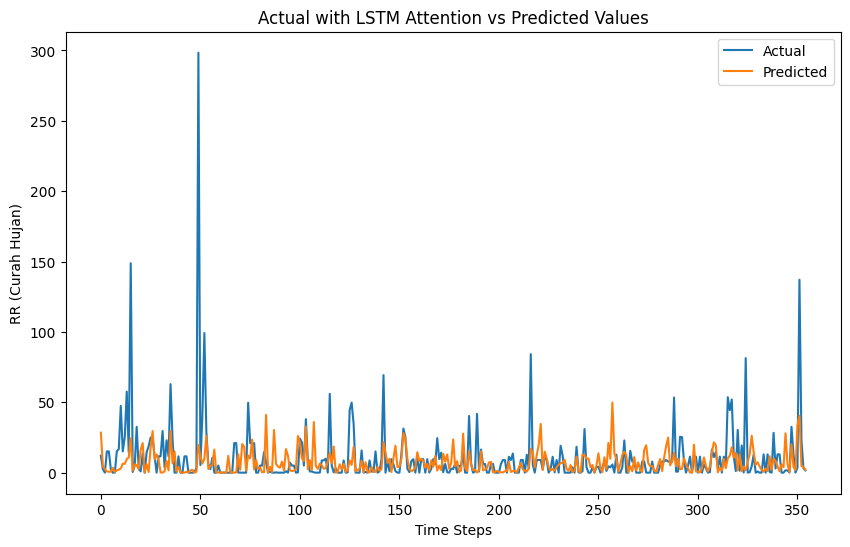

In [ ]:
# Plot prediksi vs nilai sebenarnya
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_lstm_attention, label='Predicted')
plt.title('Actual with LSTM Attention vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('RR (Curah Hujan)')
plt.legend()
plt.show()

Confusion Matrix LSTM

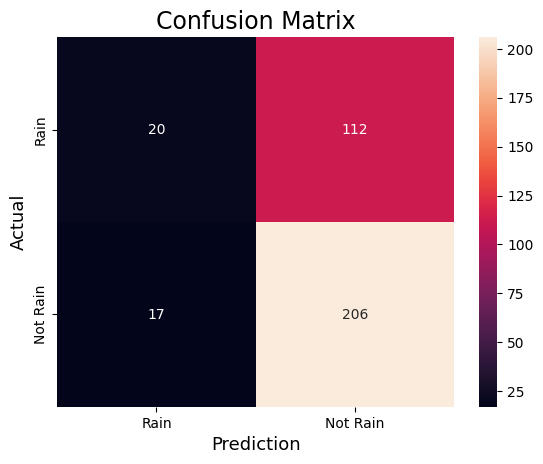

In [ ]:
# Convert continuous predictions to binary values
threshold = 0.5
y_pred_lstm_binary = (y_pred_lstm > threshold).astype(int)
y_pred_lstm_att_binary = (y_pred_lstm_attention > threshold).astype(int)

# Ensure y_test_seq is also binary for this example
y_test_seq_binary = (y_test_seq > threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test_seq_binary, y_pred_lstm_binary)

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Rain','Not Rain'],
            yticklabels=['Rain','Not Rain'])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

Confusion Matrix LSTM Attention

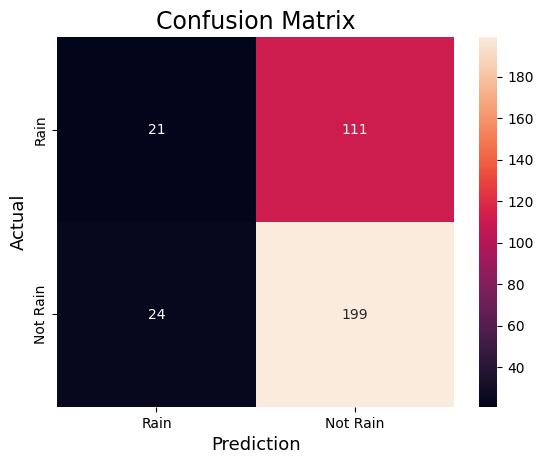

In [ ]:
# Convert continuous predictions to binary values for LSTM Attention
y_pred_lstm_att_binary = (y_pred_lstm_attention > threshold).astype(int)

# Compute the confusion matrix
cm_att = confusion_matrix(y_test_seq_binary, y_pred_lstm_att_binary)

sns.heatmap(cm_att,
            annot=True,
            fmt='g',
            xticklabels=['Rain','Not Rain'],
            yticklabels=['Rain','Not Rain'])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

Classifications Report based on Confusion Metrics

In [ ]:
#Classifications Report LSTM
print('LSTM : ')
print(classification_report(y_test_seq_binary, y_pred_lstm_binary))

#Classifications Report LSTM
print('LSTM Attention : ')
print(classification_report(y_test_seq_binary, y_pred_lstm_att_binary))

LSTM : 
              precision    recall  f1-score   support

           0       0.54      0.15      0.24       132
           1       0.65      0.92      0.76       223

    accuracy                           0.64       355
   macro avg       0.59      0.54      0.50       355
weighted avg       0.61      0.64      0.57       355

LSTM Attention : 
              precision    recall  f1-score   support

           0       0.47      0.16      0.24       132
           1       0.64      0.89      0.75       223

    accuracy                           0.62       355
   macro avg       0.55      0.53      0.49       355
weighted avg       0.58      0.62      0.56       355



Save the model

In [ ]:
model_lstm_attention.save('lstm_attention_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_lstm.save('lstm_model.h5')